<a href="https://colab.research.google.com/github/victormurcia/Simple-OCR/blob/main/OCR_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [147]:
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import numpy as np
import re

#Enable data to be extracted from my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


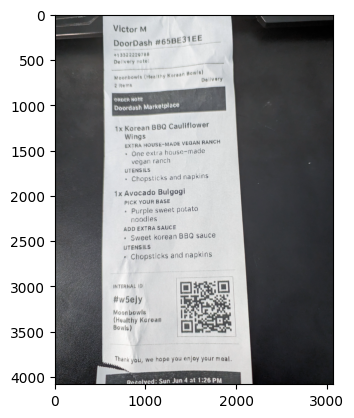

In [148]:
image = cv2.imread('/content/drive/MyDrive/receipt.jpg')

# Display the image
plt.imshow(image)
plt.axis('on')  # Remove axis ticks and labels

# Show the plot
plt.show()

In [149]:
# Get the size of the image
height, width, channels = image.shape
print(height, width, channels)

4080 3072 3


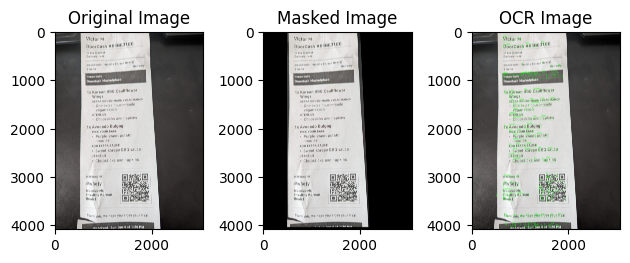

In [150]:
def simple_ocr(image):
  # Create an empty mask with zeros, same size as the image
  mask = np.zeros(image.shape[:2], dtype=np.uint8)

  # Define the region of interest (ROI) vertices
  roi_vertices = np.array([[(500, 4040), (500, 0), (2000, 0), (2200, 4040)]], dtype=np.int32)

  # Draw the ROI polygon on the mask as white (255)
  cv2.fillPoly(mask, roi_vertices, 255)

  # Apply the mask to the image using bitwise AND operation
  masked_image = cv2.bitwise_and(image, image, mask=mask)

  # Convert the masked image to grayscale
  gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

  # Perform OCR on the grayscale image within the ROI
  custom_config = r'--oem 3 --psm 6'  # Custom configuration for Tesseract
  results = pytesseract.image_to_data(gray, lang='eng', config=custom_config, output_type=Output.DICT)

  # Define a regular expression pattern to filter out undesired text regions
  pattern = r'^[a-zA-Z0-9]+$'

  # Extract the text regions and their corresponding bounding boxes, excluding undesired patterns
  text_regions = []
  for i, text in enumerate(results['text']):
      cleaned_text = re.sub(r'[^a-zA-Z0-9]', '', text)
      if re.match(pattern, cleaned_text):
          x, y, w, h = results['left'][i], results['top'][i], results['width'][i], results['height'][i]
          text_regions.append((cleaned_text, (x, y, w, h)))

  # Draw bounding boxes and text on the original image
  output_image = image.copy()
  for text, (x, y, w, h) in text_regions:
      cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(output_image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
  # Create a figure and two subplots
  fig, axs = plt.subplots(1, 3)

  # Convert BGR to RGB for correct color display in Matplotlib
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
  output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

  # Set titles for subplots
  titles = ['Original Image', 'Masked Image','OCR Image']

  # Iterate over subplots using ravel()
  for ax, img, title in zip(axs.ravel(), [image_rgb, masked_image_rgb,output_image_rgb], titles):
      ax.imshow(img)
      ax.set_title(title)
      ax.axis('on')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

  return output_image_rgb,text_regions

#Define image
image = cv2.imread('/content/drive/MyDrive/receipt.jpg')

output_image_rgb,text_regions = simple_ocr(image)